# Neural Network Training for Liver and Tumor Segmentation

This notebook implements a densely-connected U-Net (Dense U-Net) to train two models:
1. Liver segmentation (binary: liver vs background)
2. Tumor segmentation (binary: tumor vs background) using liver-masked volumes

## Volume_Files
Place full CT volumes in `data/Volume_Files`

## Segmentation_Files
Label convention in segmentation files:
- 0 background
- 1 liver
- 2 tumor

## 1. Import Required Libraries

In [1]:
import os
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
# Dense block and Dense U-Net implementation (compact)
class DenseLayer(nn.Module):
    def __init__(self, in_ch, growth_rate):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_ch, growth_rate, kernel_size=3, padding=1, bias=False)
    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], dim=1)

class DenseBlock(nn.Module):
    def __init__(self, in_ch, growth_rate, n_layers):
        super().__init__()
        layers = []
        ch = in_ch
        for i in range(n_layers):
            layers.append(DenseLayer(ch, growth_rate))
            ch += growth_rate
        self.net = nn.Sequential(*layers)
        self.out_ch = ch
    def forward(self, x):
        return self.net(x)

class TransitionDown(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        return self.pool(self.conv(x))

class TransitionUp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
    def forward(self, x):
        return self.up(x)

class DenseUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, growth_rate=16, layers_per_block=[4,5,7,10]):
        super().__init__()
        # initial conv
        self.init_conv = nn.Conv2d(in_channels, growth_rate*2, kernel_size=3, padding=1, bias=False)
        ch = growth_rate*2
        # encoder
        self.down_blocks = nn.ModuleList()
        self.trans_downs = nn.ModuleList()
        self.skip_channels = []
        for l in layers_per_block:
            db = DenseBlock(ch, growth_rate, l)
            self.down_blocks.append(db)
            ch = db.out_ch
            self.skip_channels.append(ch)
            td = TransitionDown(ch, ch)
            self.trans_downs.append(td)
        # bottleneck
        self.bottleneck = DenseBlock(ch, growth_rate, 12)
        prev_ch = self.bottleneck.out_ch
        # decoder (mirror) - use encoder skip sizes to compute inputs
        self.trans_up = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        for l, skip_ch in zip(reversed(layers_per_block), reversed(self.skip_channels)):
            tu = TransitionUp(prev_ch, prev_ch // 2)
            self.trans_up.append(tu)
            tu_out_ch = prev_ch // 2
            db_in_ch = tu_out_ch + skip_ch
            db = DenseBlock(db_in_ch, growth_rate, l)
            self.up_blocks.append(db)
            prev_ch = db.out_ch
        self.final_conv = nn.Conv2d(prev_ch, out_channels, kernel_size=1)
    def forward(self, x):
        x = self.init_conv(x)
        skips = []
        for db, td in zip(self.down_blocks, self.trans_downs):
            x = db(x)
            skips.append(x)
            x = td(x)
        x = self.bottleneck(x)
        for tu, ub, skip in zip(self.trans_up, self.up_blocks, reversed(skips)):
            x = tu(x)
            # center crop skip to match if necessary (assumes powers of 2 sized inputs)
            if x.shape != skip.shape:
                _, _, H, W = x.shape
                skip = skip[:, :, :H, :W]
            x = torch.cat([x, skip], dim=1)
            x = ub(x)
        x = self.final_conv(x)
        return x

In [3]:
# Dataset for slices (2D) extracted from 3D NIfTI files with optional center crop
class LiTSSliceDataset(Dataset):
    def __init__(self, vol_paths, seg_paths, transform=None, mode='liver', crop_size=None):
        self.vol_paths = vol_paths
        self.seg_paths = seg_paths
        self.transform = transform
        self.mode = mode
        self.crop_size = crop_size
    def __len__(self):
        return len(self.vol_paths)
    def __getitem__(self, idx):
        vol = nib.load(self.vol_paths[idx]).get_fdata()
        seg = nib.load(self.seg_paths[idx]).get_fdata()
        # normalize volume to 0-1 per-volume
        vol = vol.astype(np.float32)
        vol = (vol - vol.min()) / (vol.max() - vol.min() + 1e-8)
        # choose central axial slice (or could sample many slices)
        z = vol.shape[2] // 2
        img = vol[:, :, z].astype(np.float32)
        mask = seg[:, :, z]
        # binary masks depending on mode
        if self.mode == 'liver':
            tgt = (mask == 1).astype(np.float32)
        else:
            # tumor mask only (2)
            tgt = (mask == 2).astype(np.float32)
        # optional center crop to reduce memory (crop_size: int)
        if self.crop_size is not None:
            H, W = img.shape
            cs = self.crop_size
            start_h = max(0, (H - cs) // 2)
            start_w = max(0, (W - cs) // 2)
            img = img[start_h:start_h+cs, start_w:start_w+cs]
            tgt = tgt[start_h:start_h+cs, start_w:start_w+cs]
        # add channel dim
        img = np.expand_dims(img, 0)
        tgt = np.expand_dims(tgt, 0)
        return torch.from_numpy(img), torch.from_numpy(tgt)

# Utility to pair sorted volume and segmentation files by numeric index in filename
def pair_volume_and_seg(vol_dir, seg_dir):
    vols = sorted(glob.glob(os.path.join(vol_dir, '*.nii*')))
    segs = sorted(glob.glob(os.path.join(seg_dir, '*.nii*')))
    # naive pairing: assume same order / matching indices
    return vols, segs

In [4]:
# Training utilities with memory-sparing options (mixed precision, smaller batches, subsampling)
def train_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    model.train()
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        x = x.to(device).float()
        y = y.to(device).float()
        optimizer.zero_grad()
        if scaler is not None:
            with torch.amp.autocast(device_type='cuda'):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device).float()
            y = y.to(device).float()
            with torch.amp.autocast(device_type='cuda'):
                logits = model(x)
                loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)

def bce_loss_logits(pred, targ):
    return nn.BCEWithLogitsLoss()(pred, targ)

# Memory-sparing configuration
use_amp = True
batch_size = 1
growth_rate = 8
layers_per_block = [2,2,2,2]
max_samples = None  # total vols to use (subsample to reduce memory/time). Set None to use all
crop_size = 256  # center-crop slices to this size (reduce if still OOM)

vol_dir = 'data/Volume_Files'
seg_dir = 'data/Segmentation_Files'
vols, segs = pair_volume_and_seg(vol_dir, seg_dir)
if max_samples is not None:
    vols = vols[:max_samples]
    segs = segs[:max_samples]
# quick train/val split
train_vols, val_vols, train_segs, val_segs = train_test_split(vols, segs, test_size=0.2, random_state=42)

# Liver model training setup (smaller model + crop + small batch)
liver_train_ds = LiTSSliceDataset(train_vols, train_segs, mode='liver', crop_size=crop_size)
liver_val_ds = LiTSSliceDataset(val_vols, val_segs, mode='liver', crop_size=crop_size)
liver_train_loader = DataLoader(liver_train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
liver_val_loader = DataLoader(liver_val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# free any cached GPU memory before creating model
if device.type == 'cuda':
    torch.cuda.empty_cache()

liver_model = DenseUNet(in_channels=1, out_channels=1, growth_rate=growth_rate, layers_per_block=layers_per_block).to(device)
liver_opt = optim.Adam(liver_model.parameters(), lr=1e-3)
scaler = torch.amp.GradScaler() if (use_amp and device.type=='cuda') else None

# Tumor model will be trained after liver model (uses mode='tumor')


In [5]:
# Train liver model (example; reduce epochs for quick runs)
n_epochs = 20 
print('Training liver model...')

# Initialize loss trackers
liver_train_losses = []
liver_val_losses = []

for epoch in range(1, n_epochs+1):
    train_loss = train_epoch(liver_model, liver_train_loader, liver_opt, bce_loss_logits, device, scaler)
    val_loss = eval_epoch(liver_model, liver_val_loader, bce_loss_logits, device)
    liver_train_losses.append(train_loss)
    liver_val_losses.append(val_loss)
    print(f'Epoch {epoch}/{n_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}')

# Save liver model (weights only)
os.makedirs('models', exist_ok=True)
torch.save(liver_model.state_dict(), os.path.join('models', 'liver_denseunet.pth'))

# Also save a full checkpoint for easier reload later (includes config and optimizer)
liver_checkpoint = {
    'epoch': n_epochs,
    'model_state_dict': liver_model.state_dict(),
    'optimizer_state_dict': liver_opt.state_dict(),
    'scaler_state_dict': scaler.state_dict() if scaler is not None else None,
    'config': {
        'model_class': 'DenseUNet',
        'model_params': {
            'in_channels': 1,
            'out_channels': 1,
            'growth_rate': growth_rate,
            'layers_per_block': layers_per_block
        },
        'training': {
            'use_amp': use_amp,
            'batch_size': batch_size,
            'crop_size': crop_size
        }
    }
}
torch.save(liver_checkpoint, os.path.join('models', 'liver_checkpoint.pt'))

# Free GPU memory used by liver model before creating tumor model
if device.type == 'cuda':
    liver_model.cpu()
    del liver_model
    import gc
    gc.collect()
    torch.cuda.empty_cache()

# Prepare tumor dataset (mode='tumor') with same memory-sparing settings
tumor_train_ds = LiTSSliceDataset(train_vols, train_segs, mode='tumor', crop_size=crop_size)
tumor_val_ds = LiTSSliceDataset(val_vols, val_segs, mode='tumor', crop_size=crop_size)
tumor_train_loader = DataLoader(tumor_train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
tumor_val_loader = DataLoader(tumor_val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize tumor loss trackers
tumor_train_losses = []
tumor_val_losses = []

tumor_model = DenseUNet(in_channels=1, out_channels=1, growth_rate=growth_rate, layers_per_block=layers_per_block).to(device)
tumor_opt = optim.Adam(tumor_model.parameters(), lr=1e-3)

print('Training tumor model...')
# Train tumor model
for epoch in range(1, n_epochs+1):
    train_loss = train_epoch(tumor_model, tumor_train_loader, tumor_opt, bce_loss_logits, device, scaler)
    val_loss = eval_epoch(tumor_model, tumor_val_loader, bce_loss_logits, device)
    tumor_train_losses.append(train_loss)
    tumor_val_losses.append(val_loss)
    print(f'Tumor Epoch {epoch}/{n_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}')

# Save tumor model (weights only)
torch.save(tumor_model.state_dict(), os.path.join('models', 'tumor_denseunet.pth'))

# Also save a full checkpoint for tumor
tumor_checkpoint = {
    'epoch': n_epochs,
    'model_state_dict': tumor_model.state_dict(),
    'optimizer_state_dict': tumor_opt.state_dict(),
    'scaler_state_dict': scaler.state_dict() if scaler is not None else None,
    'config': {
        'model_class': 'DenseUNet',
        'model_params': {
            'in_channels': 1,
            'out_channels': 1,
            'growth_rate': growth_rate,
            'layers_per_block': layers_per_block
        },
        'training': {
            'use_amp': use_amp,
            'batch_size': batch_size,
            'crop_size': crop_size
        }
    }
}
torch.save(tumor_checkpoint, os.path.join('models', 'tumor_checkpoint.pt'))

print('Training complete — models saved to models/')

Training liver model...


100%|██████████| 104/104 [02:33<00:00,  1.48s/it]


Epoch 1/20: train_loss=0.2117, val_loss=0.4268


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 2/20: train_loss=0.1664, val_loss=0.6725


100%|██████████| 104/104 [02:27<00:00,  1.42s/it]


Epoch 3/20: train_loss=0.1283, val_loss=0.8162


100%|██████████| 104/104 [02:42<00:00,  1.57s/it]


Epoch 4/20: train_loss=0.1216, val_loss=0.9281


100%|██████████| 104/104 [02:34<00:00,  1.49s/it]


Epoch 5/20: train_loss=0.1070, val_loss=0.3229


100%|██████████| 104/104 [02:33<00:00,  1.47s/it]


Epoch 6/20: train_loss=0.0901, val_loss=0.5140


100%|██████████| 104/104 [02:35<00:00,  1.50s/it]


Epoch 7/20: train_loss=0.1004, val_loss=1.0919


100%|██████████| 104/104 [02:36<00:00,  1.50s/it]


Epoch 8/20: train_loss=0.0900, val_loss=0.4880


100%|██████████| 104/104 [02:33<00:00,  1.48s/it]


Epoch 9/20: train_loss=0.0739, val_loss=0.4827


100%|██████████| 104/104 [02:35<00:00,  1.50s/it]


Epoch 10/20: train_loss=0.0724, val_loss=0.4408


100%|██████████| 104/104 [02:31<00:00,  1.45s/it]


Epoch 11/20: train_loss=0.0657, val_loss=0.3991


100%|██████████| 104/104 [02:32<00:00,  1.47s/it]


Epoch 12/20: train_loss=0.0572, val_loss=0.3113


100%|██████████| 104/104 [02:36<00:00,  1.50s/it]


Epoch 13/20: train_loss=0.0572, val_loss=0.4267


100%|██████████| 104/104 [02:34<00:00,  1.48s/it]


Epoch 14/20: train_loss=0.0677, val_loss=1.1929


100%|██████████| 104/104 [02:32<00:00,  1.46s/it]


Epoch 15/20: train_loss=0.0525, val_loss=0.7132


100%|██████████| 104/104 [02:35<00:00,  1.49s/it]


Epoch 16/20: train_loss=0.0494, val_loss=0.6626


100%|██████████| 104/104 [02:34<00:00,  1.48s/it]


Epoch 17/20: train_loss=0.0428, val_loss=0.4401


100%|██████████| 104/104 [02:31<00:00,  1.46s/it]


Epoch 18/20: train_loss=0.0434, val_loss=1.1411


100%|██████████| 104/104 [02:35<00:00,  1.50s/it]


Epoch 19/20: train_loss=0.0485, val_loss=0.8776


100%|██████████| 104/104 [02:33<00:00,  1.47s/it]


Epoch 20/20: train_loss=0.0410, val_loss=0.5306
Training tumor model...


100%|██████████| 104/104 [02:32<00:00,  1.47s/it]


Tumor Epoch 1/20: train_loss=0.0615, val_loss=0.0182


100%|██████████| 104/104 [02:33<00:00,  1.47s/it]


Tumor Epoch 2/20: train_loss=0.0343, val_loss=0.0215


100%|██████████| 104/104 [02:34<00:00,  1.48s/it]


Tumor Epoch 3/20: train_loss=0.0338, val_loss=0.0231


100%|██████████| 104/104 [02:31<00:00,  1.46s/it]


Tumor Epoch 4/20: train_loss=0.0322, val_loss=0.0306


100%|██████████| 104/104 [02:32<00:00,  1.47s/it]


Tumor Epoch 5/20: train_loss=0.0314, val_loss=0.0178


100%|██████████| 104/104 [02:35<00:00,  1.49s/it]


Tumor Epoch 6/20: train_loss=0.0294, val_loss=0.0354


100%|██████████| 104/104 [02:33<00:00,  1.48s/it]


Tumor Epoch 7/20: train_loss=0.0302, val_loss=0.0303


100%|██████████| 104/104 [02:33<00:00,  1.48s/it]


Tumor Epoch 8/20: train_loss=0.0290, val_loss=0.0258


100%|██████████| 104/104 [02:36<00:00,  1.51s/it]


Tumor Epoch 9/20: train_loss=0.0298, val_loss=0.0184


100%|██████████| 104/104 [02:33<00:00,  1.48s/it]


Tumor Epoch 10/20: train_loss=0.0280, val_loss=0.0235


100%|██████████| 104/104 [02:33<00:00,  1.48s/it]


Tumor Epoch 11/20: train_loss=0.0268, val_loss=0.0171


100%|██████████| 104/104 [02:35<00:00,  1.50s/it]


Tumor Epoch 12/20: train_loss=0.0297, val_loss=0.0205


100%|██████████| 104/104 [02:34<00:00,  1.49s/it]


Tumor Epoch 13/20: train_loss=0.0261, val_loss=0.0144


100%|██████████| 104/104 [02:33<00:00,  1.48s/it]


Tumor Epoch 14/20: train_loss=0.0254, val_loss=0.0206


100%|██████████| 104/104 [02:38<00:00,  1.52s/it]


Tumor Epoch 15/20: train_loss=0.0241, val_loss=0.0200


100%|██████████| 104/104 [02:34<00:00,  1.48s/it]


Tumor Epoch 16/20: train_loss=0.0232, val_loss=0.0140


100%|██████████| 104/104 [02:37<00:00,  1.51s/it]


Tumor Epoch 17/20: train_loss=0.0243, val_loss=0.0173


100%|██████████| 104/104 [02:37<00:00,  1.51s/it]


Tumor Epoch 18/20: train_loss=0.0230, val_loss=0.0143


100%|██████████| 104/104 [02:34<00:00,  1.49s/it]


Tumor Epoch 19/20: train_loss=0.0218, val_loss=0.0249


100%|██████████| 104/104 [02:34<00:00,  1.48s/it]


Tumor Epoch 20/20: train_loss=0.0201, val_loss=0.0289
Training complete — models saved to models/


## Checking training reliability

C:\Users\User\AppData\Local\Temp\ipykernel_10204\69442840.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


Visualizing 27 validation samples...

Sample 1/27: volume-30.nii


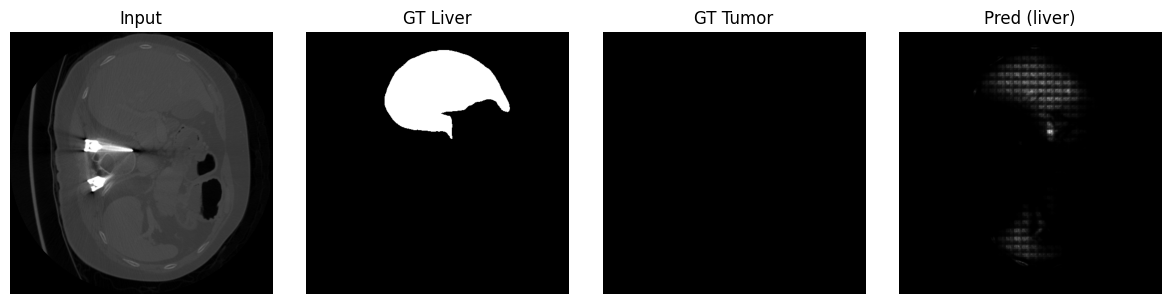

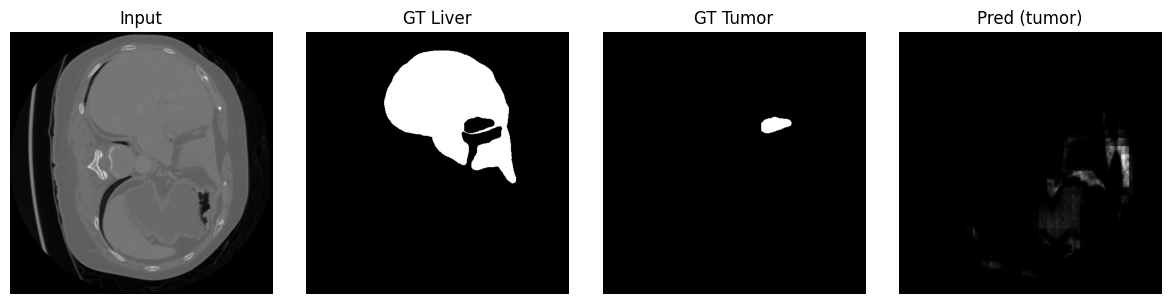


Sample 2/27: volume-17.nii


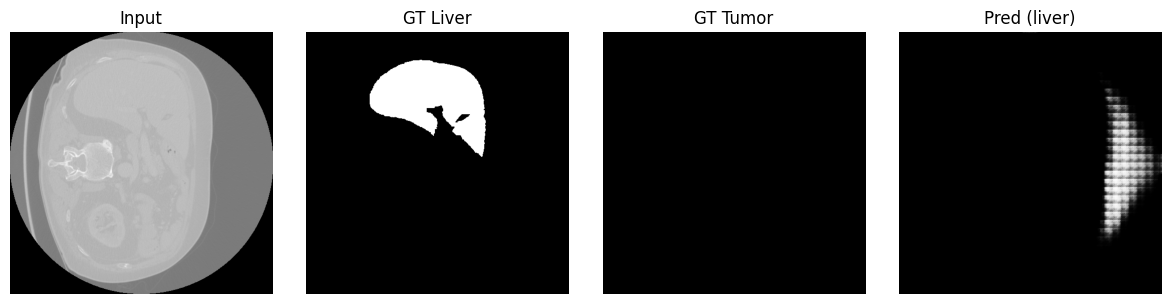

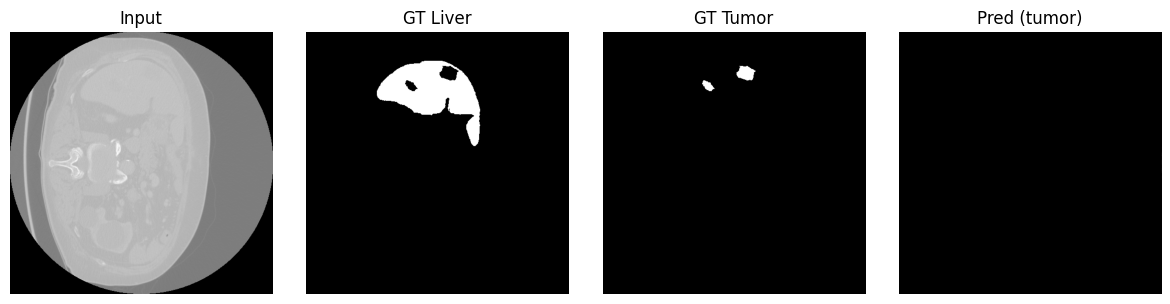


Sample 3/27: volume-115.nii


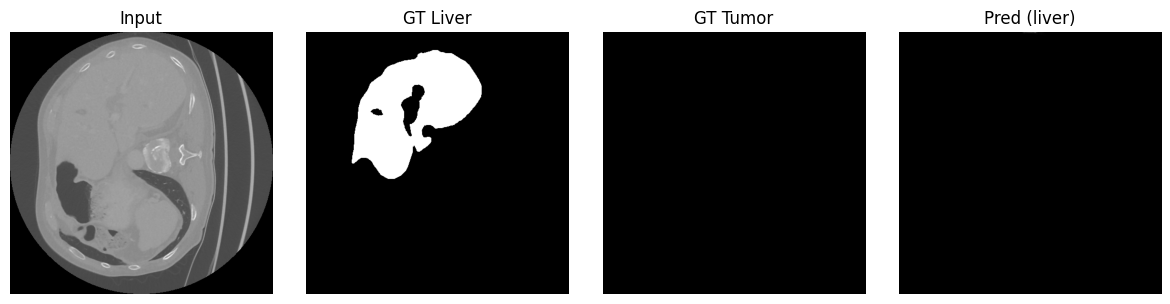

No tumors present in this sample for visualization.

Sample 4/27: volume-126.nii


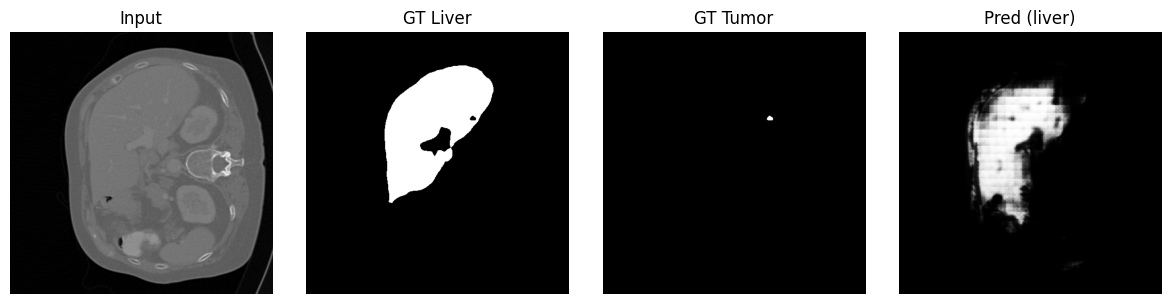

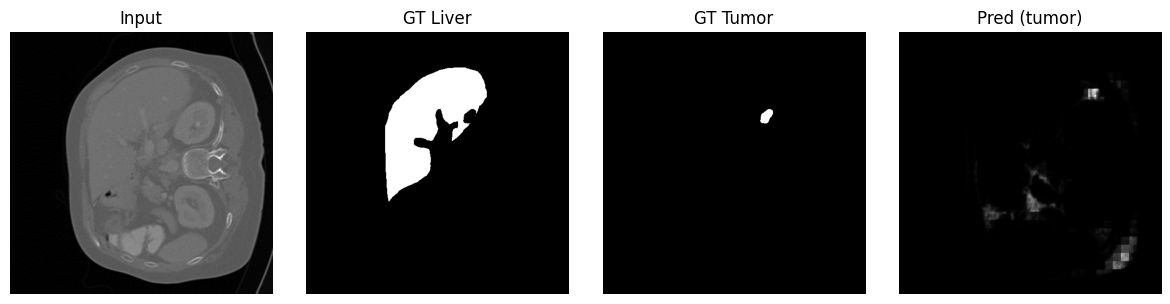


Sample 5/27: volume-85.nii


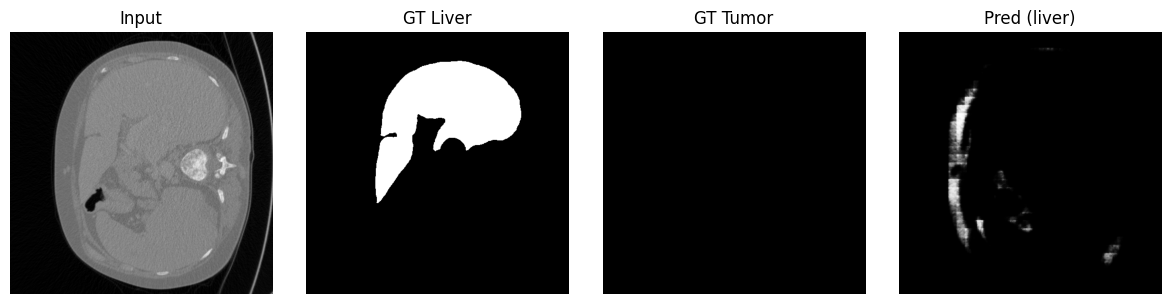

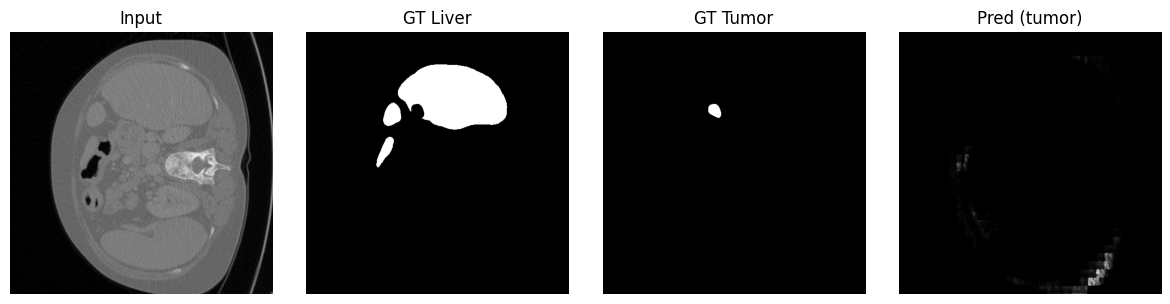


Sample 6/27: volume-31.nii


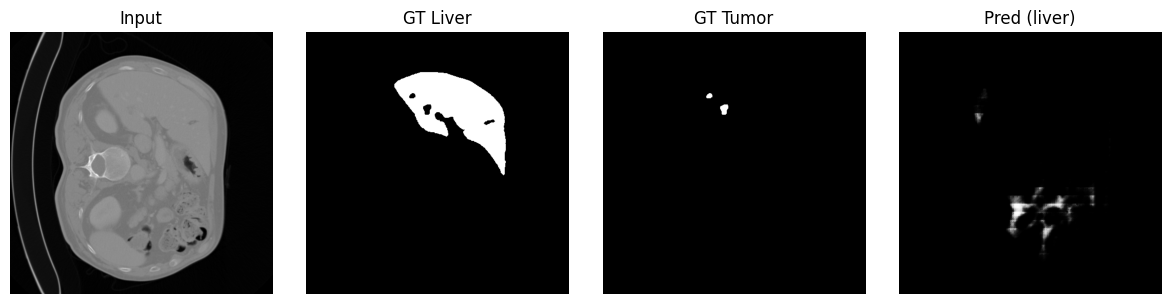

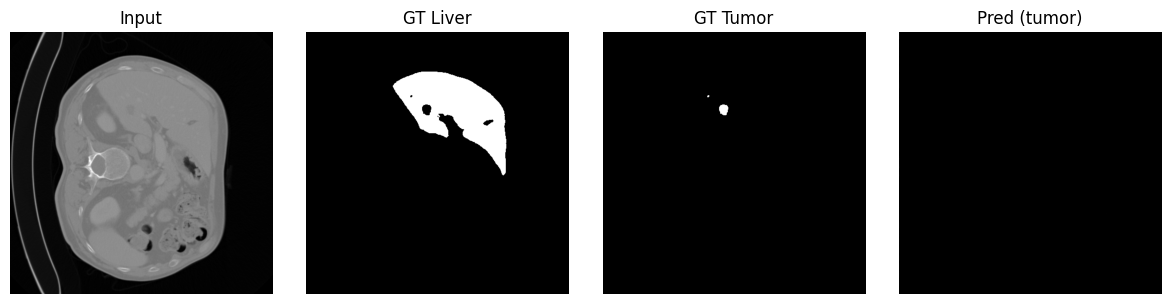


Sample 7/27: volume-43.nii


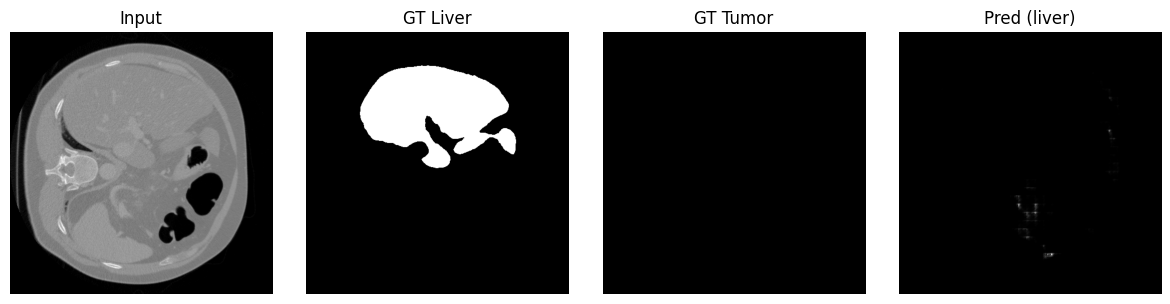

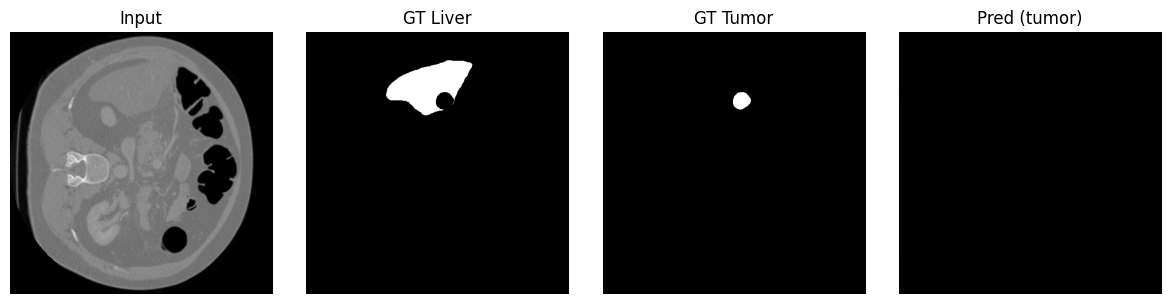


Sample 8/27: volume-76.nii


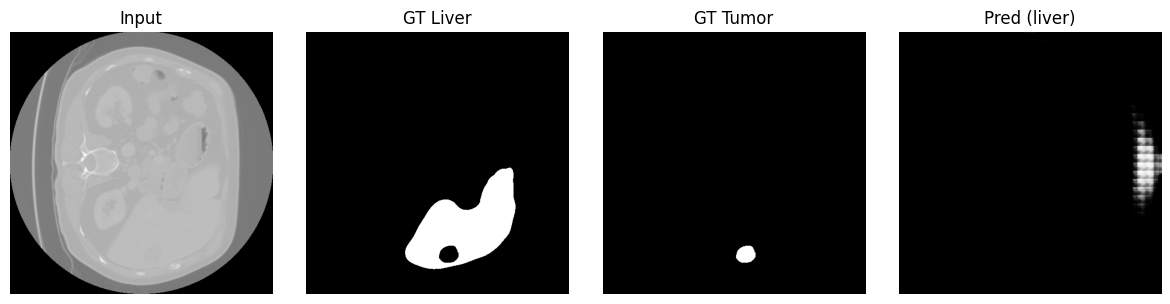

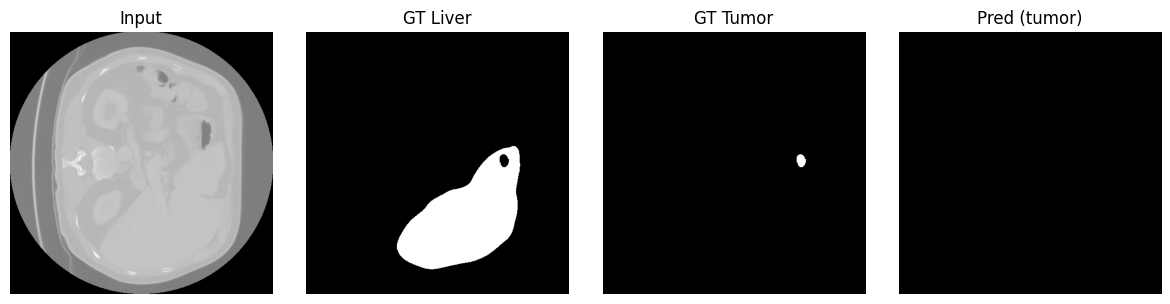


Sample 9/27: volume-54.nii


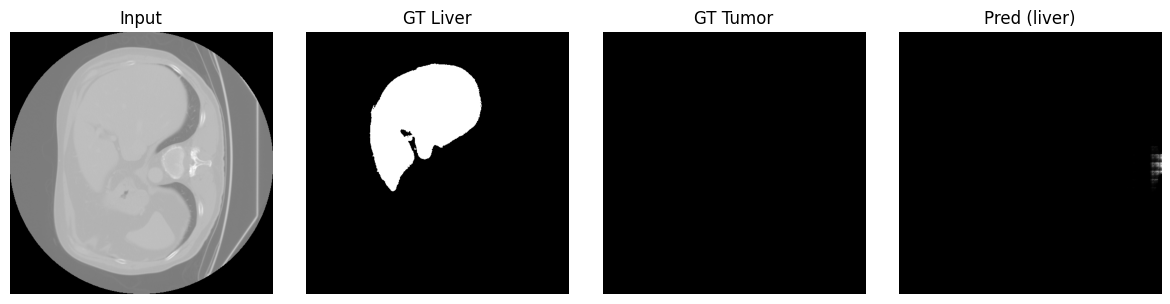

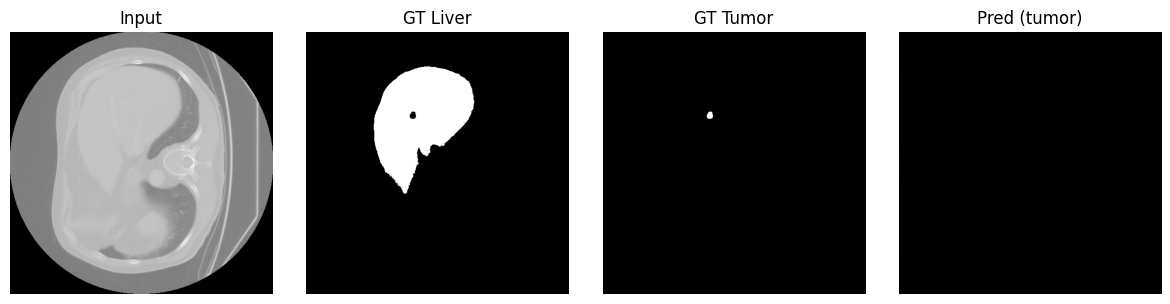


Sample 10/27: volume-121.nii


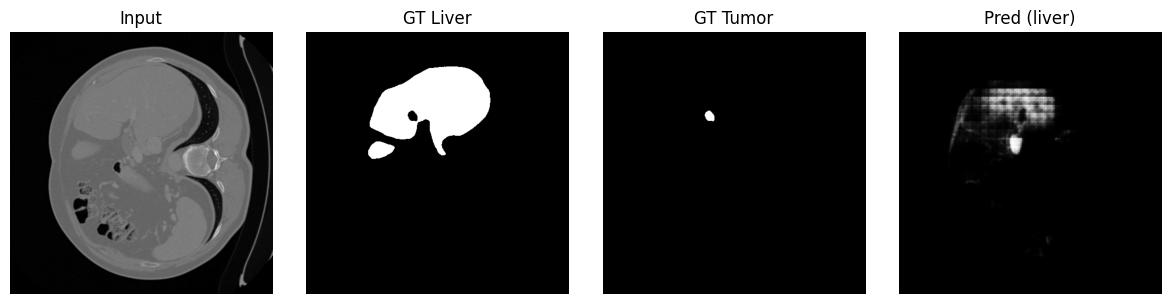

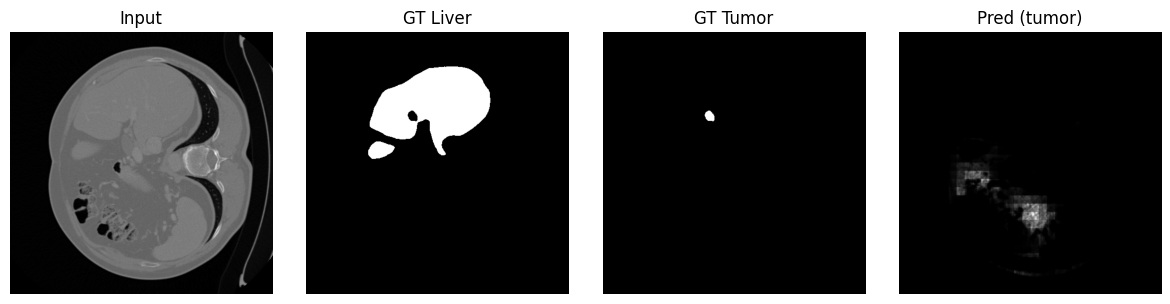


Sample 11/27: volume-67.nii


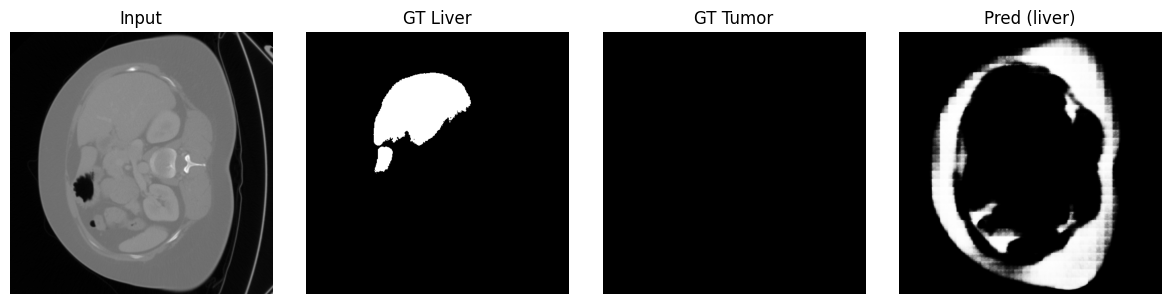

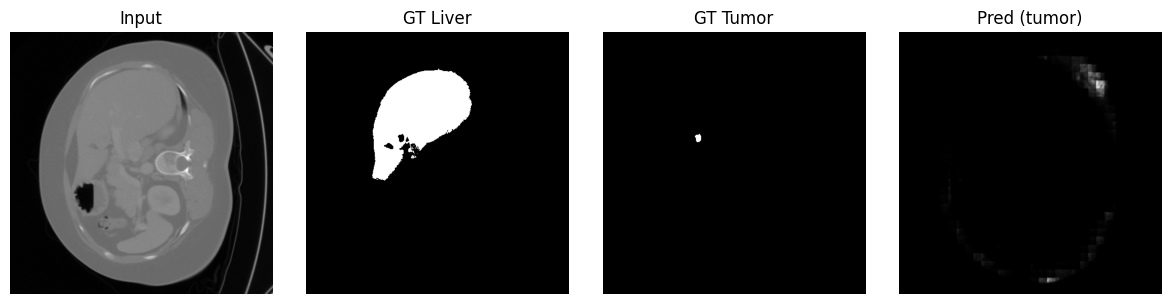


Sample 12/27: volume-122.nii


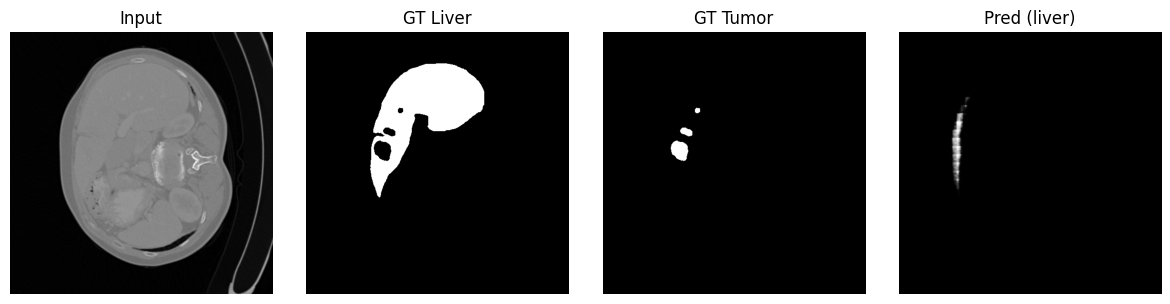

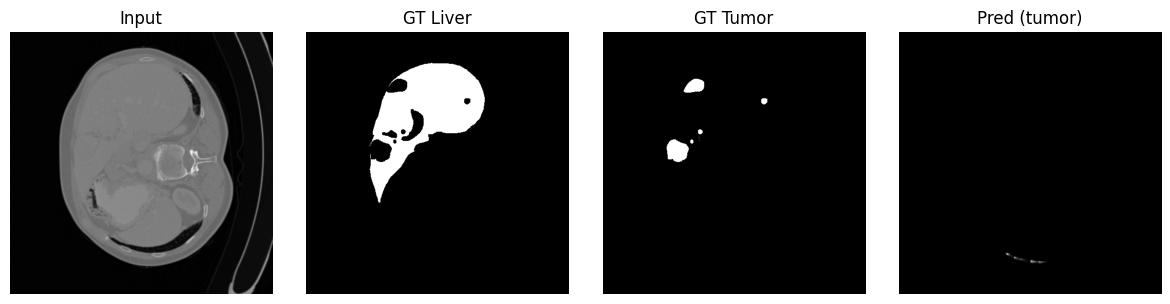


Sample 13/27: volume-39.nii


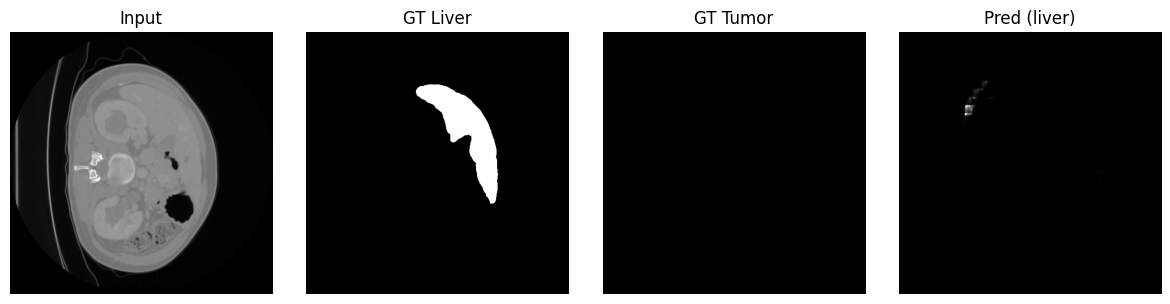

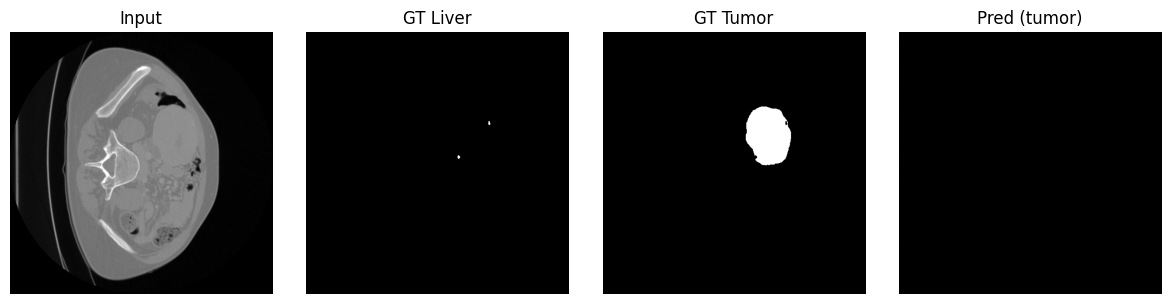


Sample 14/27: volume-101.nii


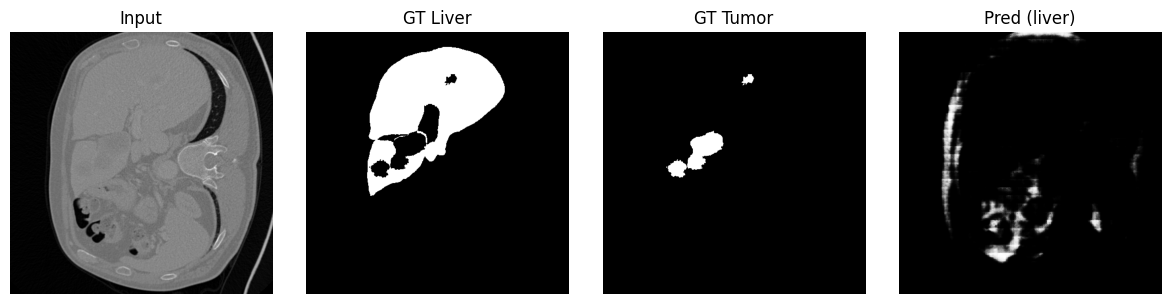

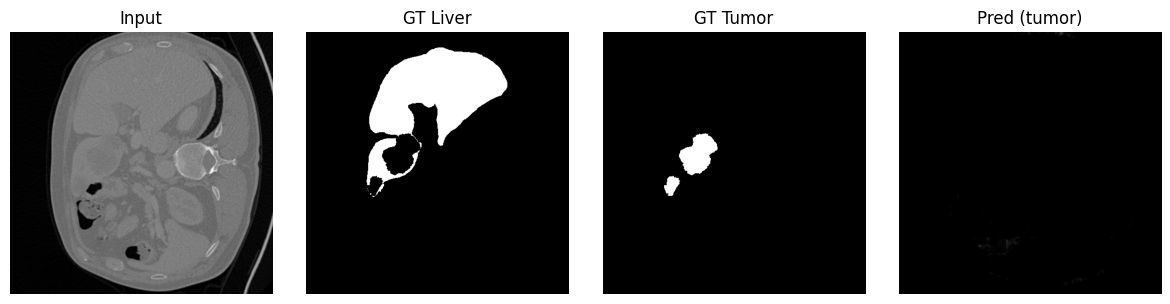


Sample 15/27: volume-69.nii


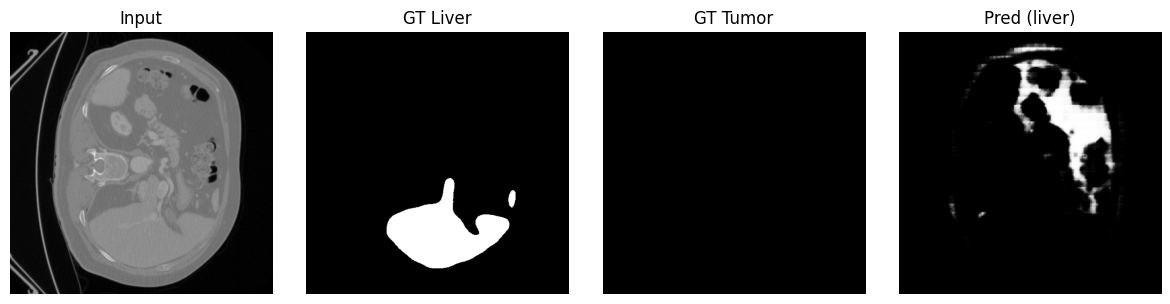

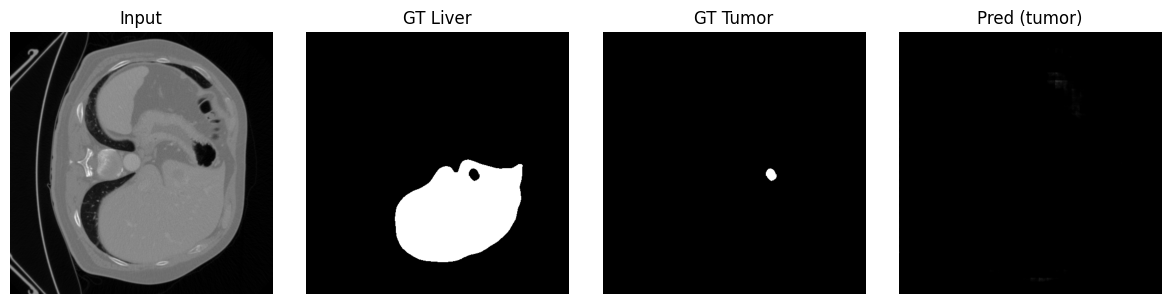


Sample 16/27: volume-71.nii


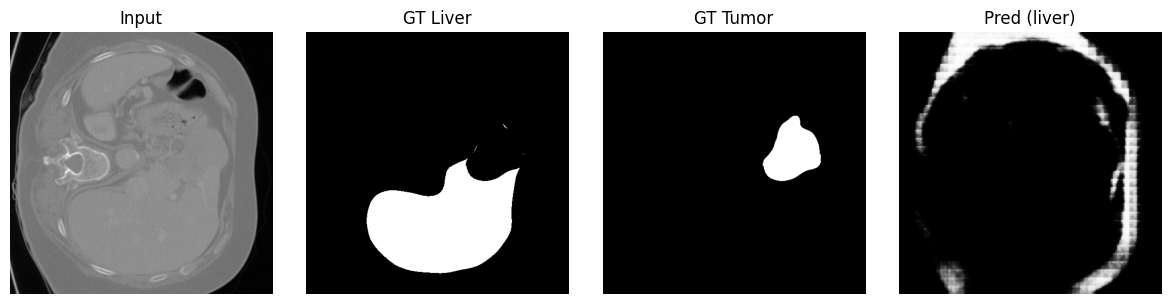

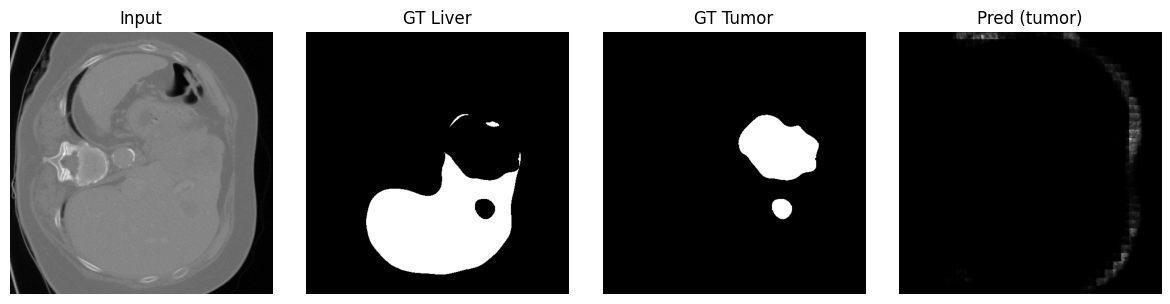


Sample 17/27: volume-130.nii


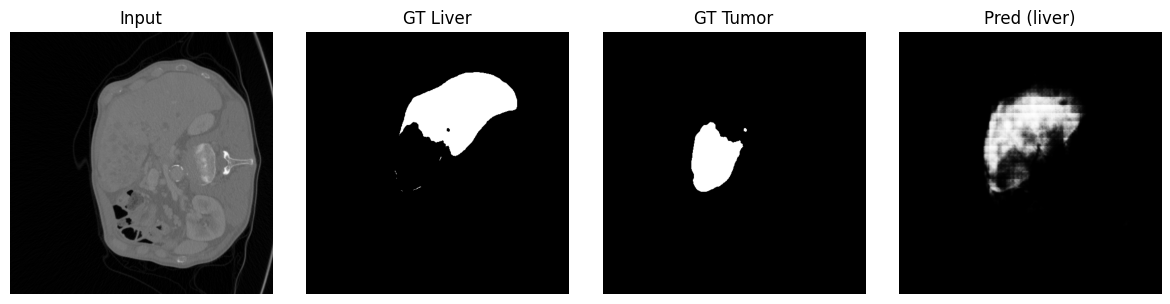

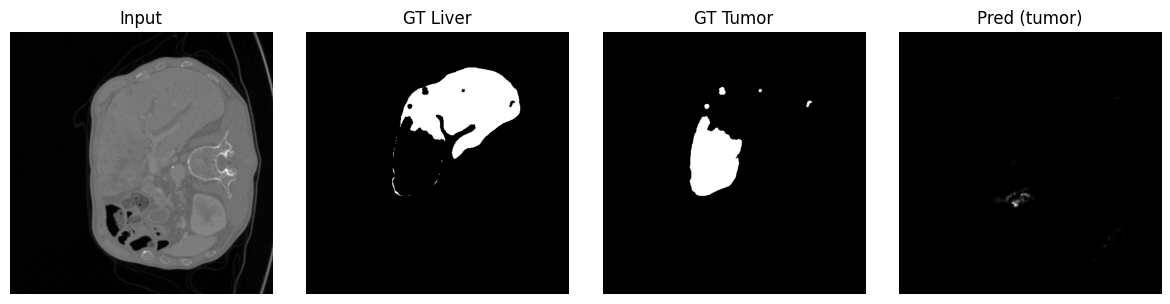


Sample 18/27: volume-53.nii


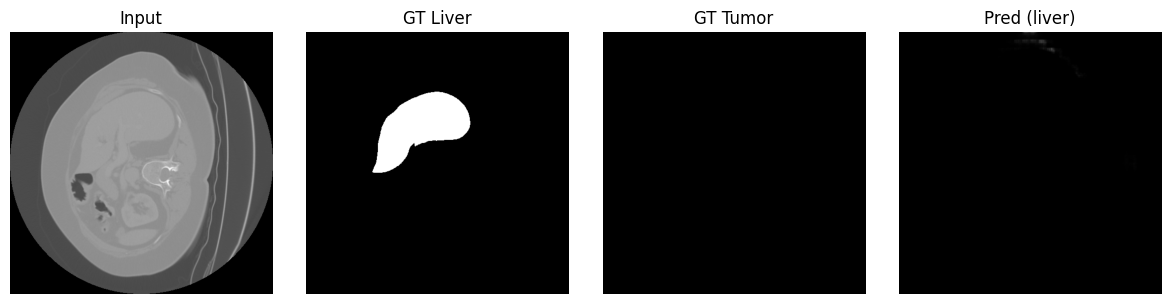

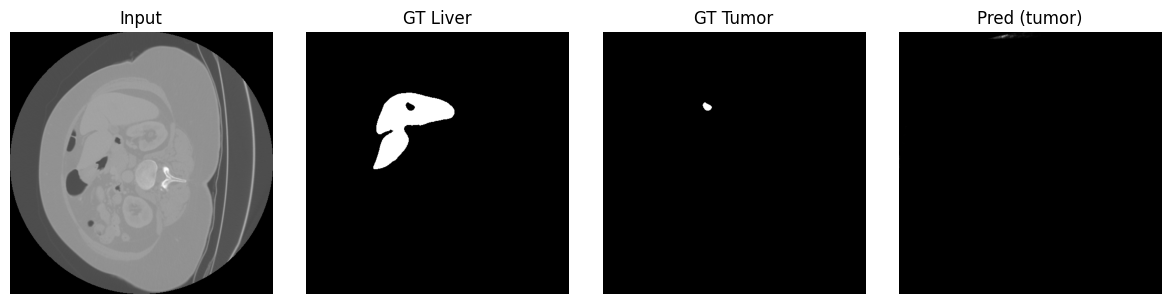


Sample 19/27: volume-65.nii


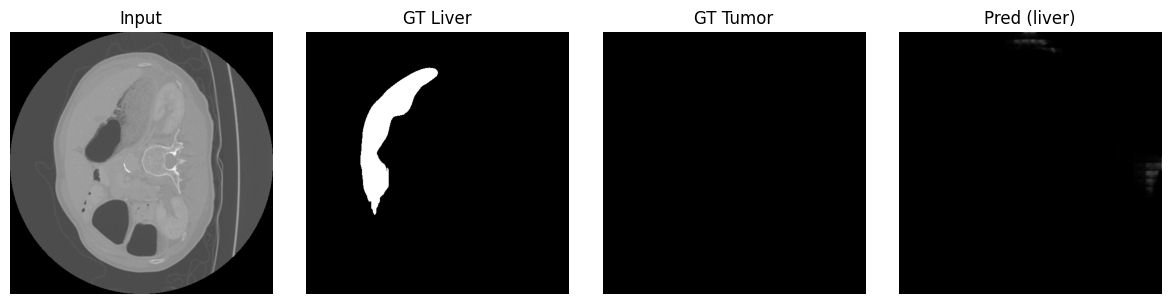

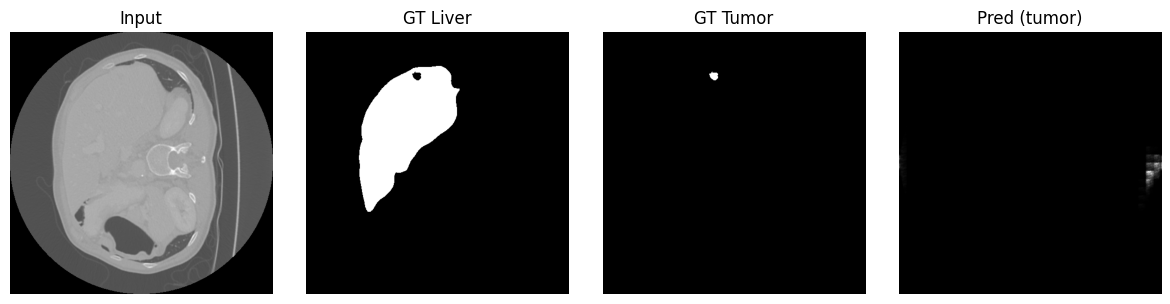


Sample 20/27: volume-57.nii


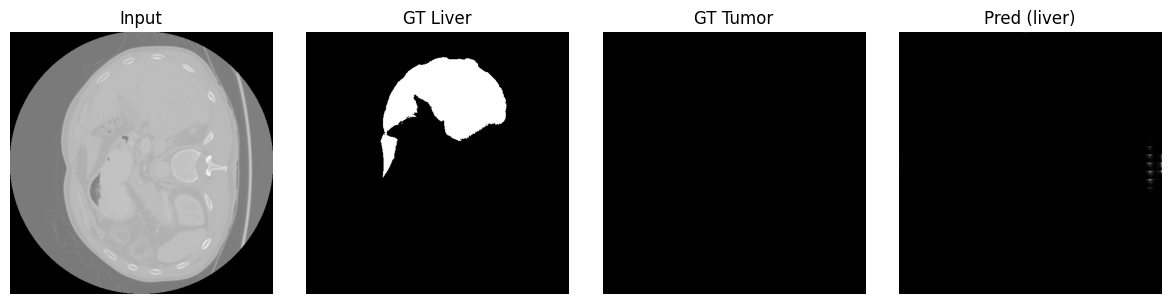

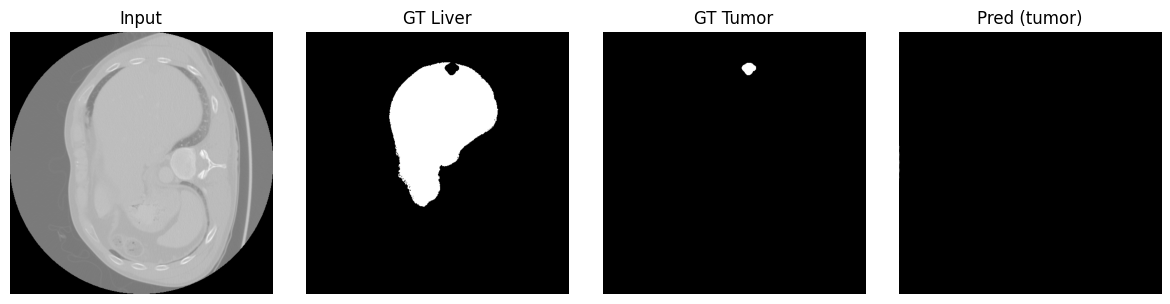


Sample 21/27: volume-114.nii


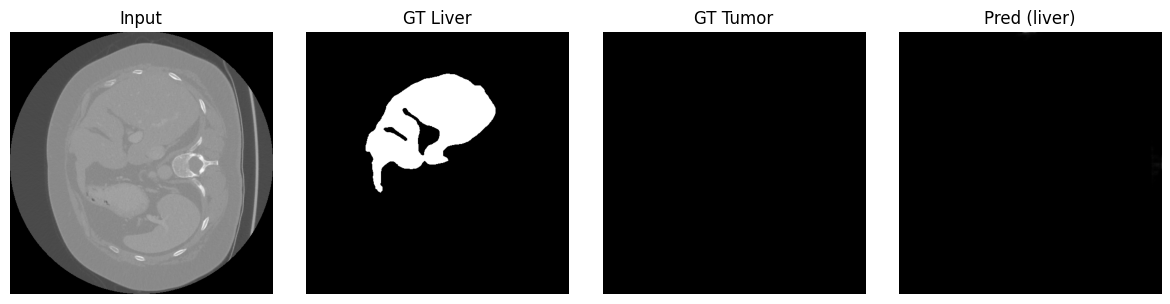

No tumors present in this sample for visualization.

Sample 22/27: volume-107.nii


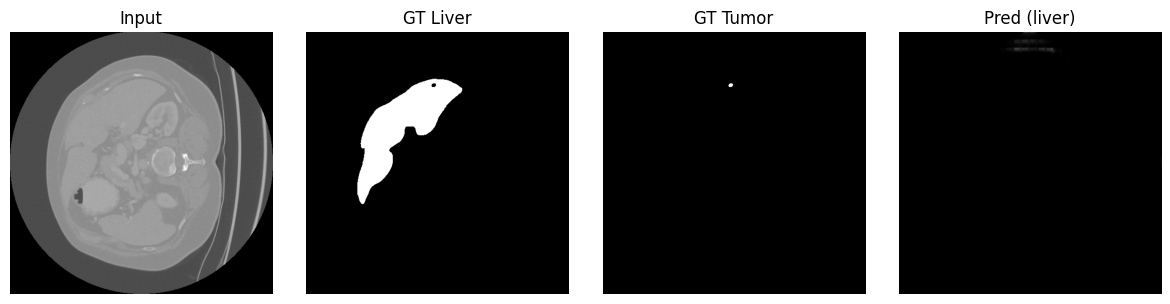

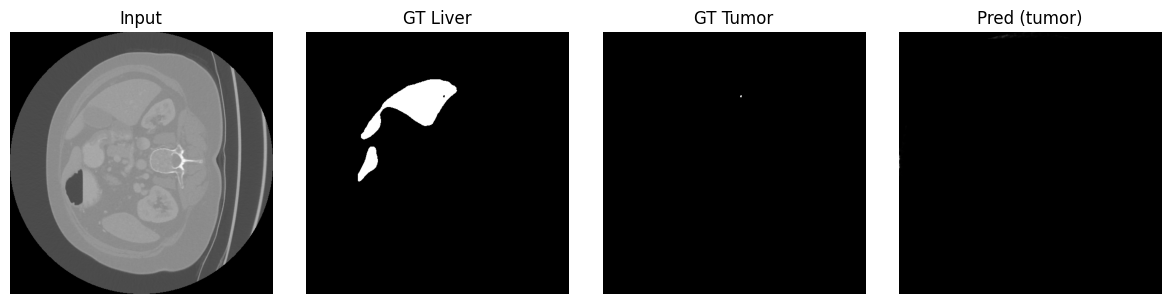


Sample 23/27: volume-91.nii


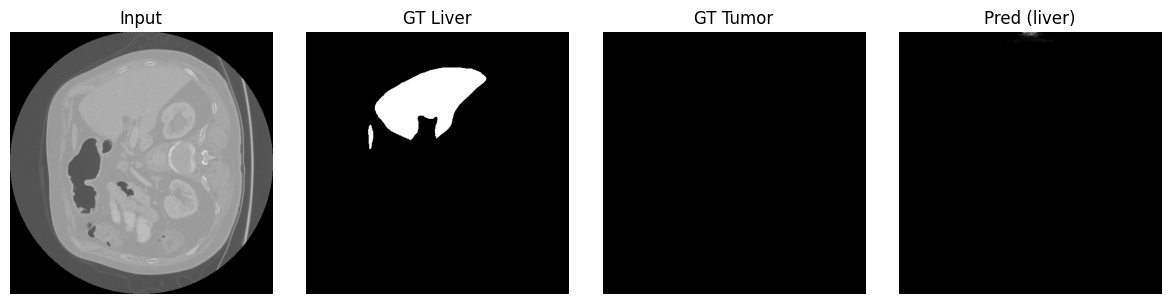

No tumors present in this sample for visualization.

Sample 24/27: volume-108.nii


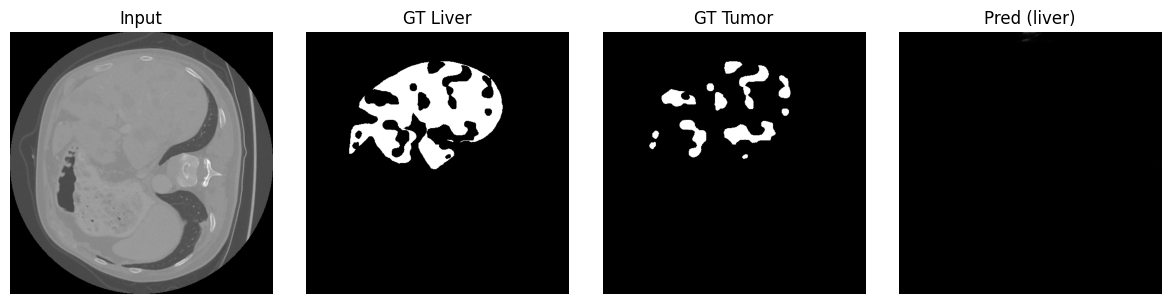

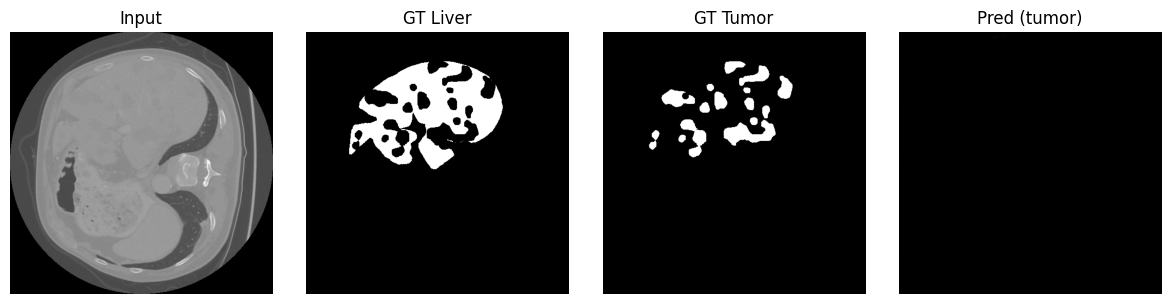


Sample 25/27: volume-96.nii


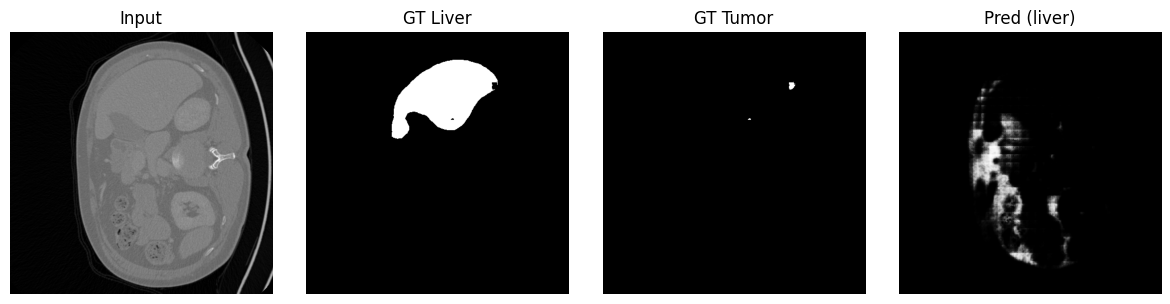

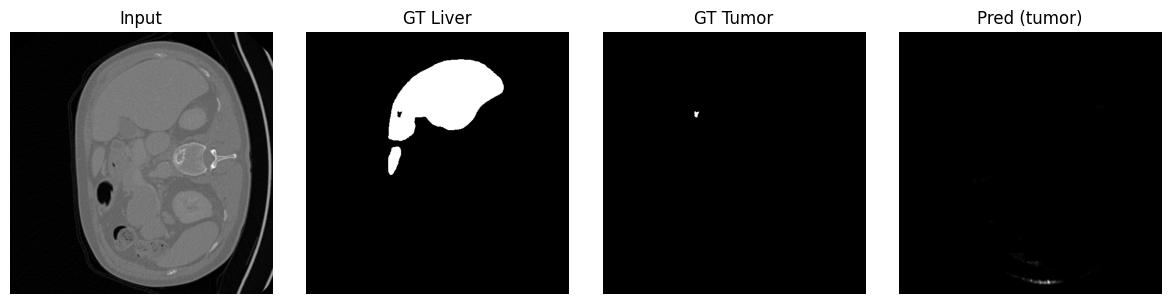


Sample 26/27: volume-21.nii


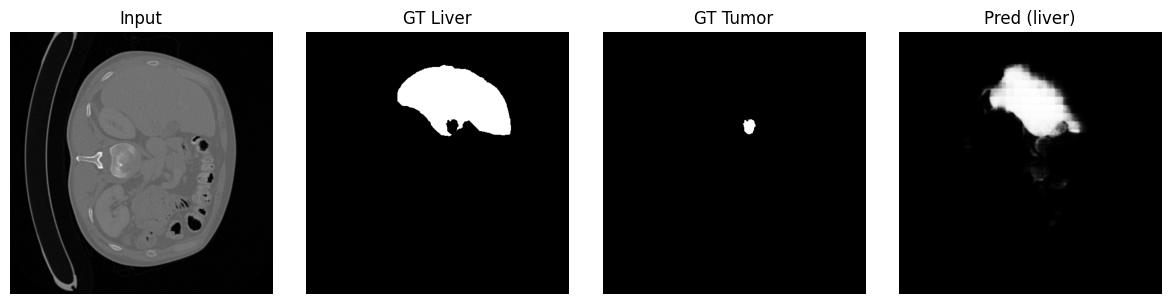

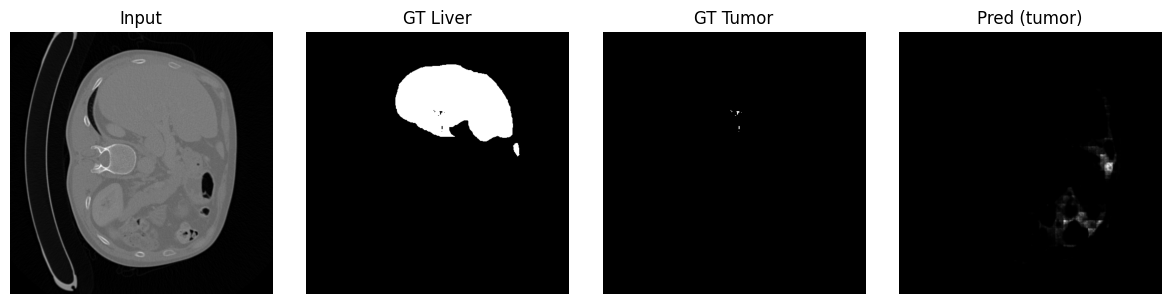


Sample 27/27: volume-44.nii


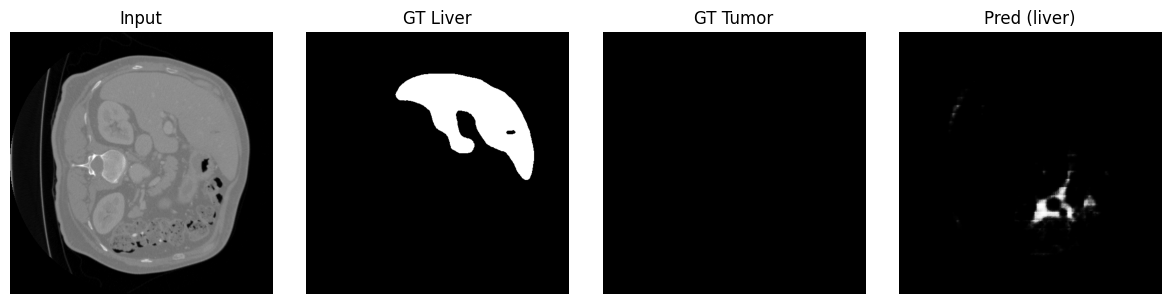

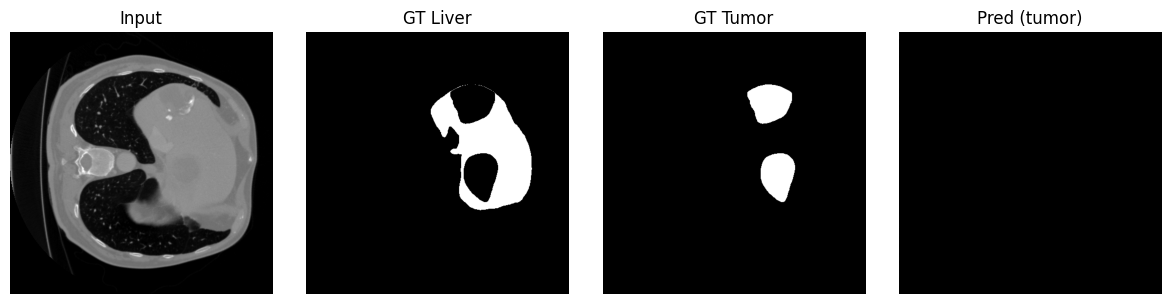

In [6]:
# Reload saved models from checkpoints and visualize
import os


def load_model_from_checkpoint(checkpoint_path, device):
    ckpt = torch.load(checkpoint_path, map_location=device)
    cfg = ckpt['config']['model_params']
    model = DenseUNet(**cfg).to(device)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()
    return model

# Prefer reloading from saved checkpoints to avoid depending on in-memory variables
liver_ckpt_path = os.path.join('models', 'liver_checkpoint.pt')
tumor_ckpt_path = os.path.join('models', 'tumor_checkpoint.pt')

liver_model_loaded = None
tumor_model_loaded = None

if os.path.exists(liver_ckpt_path):
    liver_model_loaded = load_model_from_checkpoint(liver_ckpt_path, device)
else:
    print(f"Liver checkpoint not found at {liver_ckpt_path}.")

if os.path.exists(tumor_ckpt_path):
    tumor_model_loaded = load_model_from_checkpoint(tumor_ckpt_path, device)
else:
    print(f"Tumor checkpoint not found at {tumor_ckpt_path}.")

# Helper to find a sample index whose segmentation contains the desired label
# label=1 for liver, label=2 for tumor

def find_sample_with_label(seg_paths, label=2):
    for i, sp in enumerate(seg_paths):
        seg_arr = nib.load(sp).get_fdata()
        if (seg_arr == label).any():
            return i
    return None

# Quick visualization helper: show input, ground truth, and predicted mask (uses a model)
# target: 'tumor' or 'liver' helps auto-pick a slice containing that label when z is None

def visualize_sample(model, vol_path, seg_path, z=None, title_suffix='', target='auto'):
    model.eval()
    vol = nib.load(vol_path).get_fdata().astype(np.float32)
    seg = nib.load(seg_path).get_fdata()
    if z is None:
        if target == 'tumor':
            tumor_slices = np.where((seg == 2).any(axis=(0, 1)))[0]
            z = int(tumor_slices[len(tumor_slices)//2]) if tumor_slices.size > 0 else vol.shape[2] // 2
        elif target == 'liver':
            liver_slices = np.where((seg == 1).any(axis=(0, 1)))[0]
            z = int(liver_slices[len(liver_slices)//2]) if liver_slices.size > 0 else vol.shape[2] // 2
        else:
            z = vol.shape[2] // 2
    img = vol[:, :, z]
    img_n = (img - img.min()) / (img.max() - img.min() + 1e-8)
    x = torch.from_numpy(img_n[np.newaxis, np.newaxis, :, :]).to(device).float()
    with torch.no_grad():
        logits = model(x)
        preds = torch.sigmoid(logits).cpu().numpy()[0, 0]
    gt_liver = (seg[:, :, z] == 1).astype(np.float32)
    gt_tumor = (seg[:, :, z] == 2).astype(np.float32)
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    axs[0].imshow(img, cmap='gray'); axs[0].set_title('Input')
    axs[1].imshow(gt_liver, cmap='gray'); axs[1].set_title('GT Liver')
    axs[2].imshow(gt_tumor, cmap='gray'); axs[2].set_title('GT Tumor')
    axs[3].imshow(preds, cmap='gray'); axs[3].set_title(f'Pred {title_suffix}'.strip())
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize validation samples for ALL files using reloaded liver/tumor models if available
if len(val_vols) > 0:
    print(f"Visualizing {len(val_vols)} validation samples...")
    for i, (vp, sp) in enumerate(zip(val_vols, val_segs), start=1):
        print(f"\nSample {i}/{len(val_vols)}: {os.path.basename(vp)}")
        # Liver visualization (always attempted if model available)
        if liver_model_loaded is not None:
            visualize_sample(liver_model_loaded, vp, sp, title_suffix='(liver)', target='liver')
        else:
            print('Liver model unavailable for visualization.')
        # Tumor visualization (only if tumor label exists in this sample)
        if tumor_model_loaded is not None:
            seg_arr = nib.load(sp).get_fdata()
            if (seg_arr == 2).any():
                visualize_sample(tumor_model_loaded, vp, sp, title_suffix='(tumor)', target='tumor')
            else:
                print('No tumors present in this sample for visualization.')
        else:
            print('Tumor model unavailable for visualization.')
else:
    print('No validation samples available for visualization.')

# Training metrics of the model

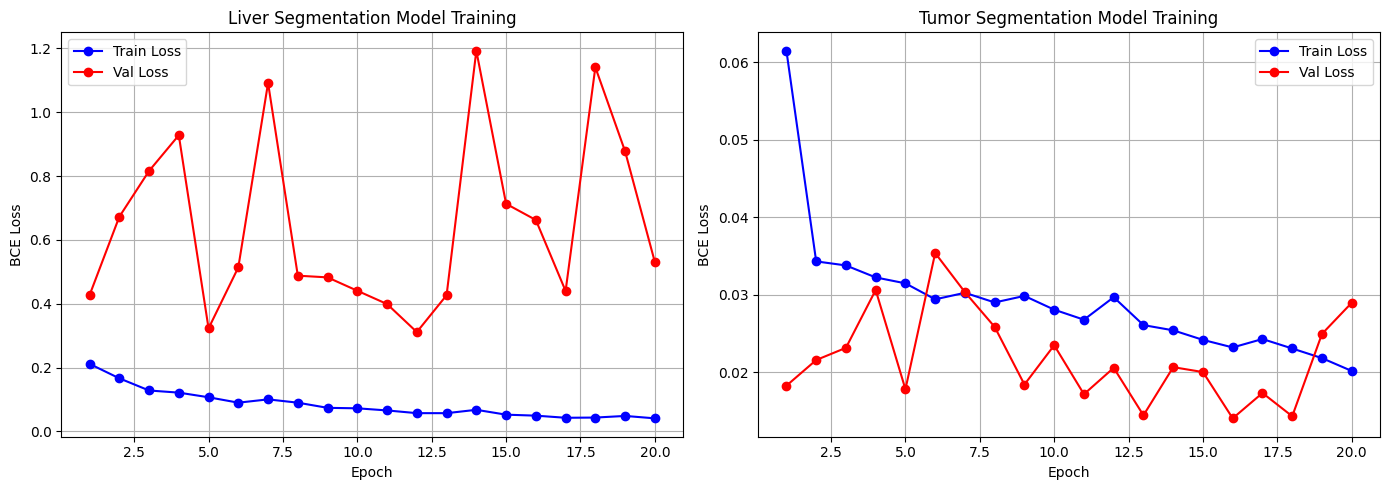

Final liver train loss: 0.040972
Final liver val loss: 0.530612
Final tumor train loss: 0.020138
Final tumor val loss: 0.028941


In [7]:
# Plot training metrics for both liver and tumor models

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Liver model metrics
if 'liver_train_losses' in globals() and isinstance(liver_train_losses, list) and len(liver_train_losses) > 0:
    epochs_range_liver = range(1, len(liver_train_losses) + 1)
    axes[0].plot(epochs_range_liver, liver_train_losses, 'b-o', label='Train Loss')
    axes[0].plot(epochs_range_liver, liver_val_losses, 'r-o', label='Val Loss')
else:
    axes[0].text(0.5, 0.5, 'No liver loss history found.\nRe-run the training cell.', ha='center', va='center')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].set_title('Liver Segmentation Model Training')
axes[0].legend()
axes[0].grid(True)

# Tumor model metrics
if 'tumor_train_losses' in globals() and isinstance(tumor_train_losses, list) and len(tumor_train_losses) > 0:
    epochs_range_tumor = range(1, len(tumor_train_losses) + 1)
    axes[1].plot(epochs_range_tumor, tumor_train_losses, 'b-o', label='Train Loss')
    axes[1].plot(epochs_range_tumor, tumor_val_losses, 'r-o', label='Val Loss')
else:
    axes[1].text(0.5, 0.5, 'No tumor loss history found.\nRe-run the training cell.', ha='center', va='center')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('BCE Loss')
axes[1].set_title('Tumor Segmentation Model Training')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print final epoch losses when available
if 'liver_train_losses' in globals() and len(liver_train_losses) > 0:
    print(f"Final liver train loss: {liver_train_losses[-1]:.6f}")
    print(f"Final liver val loss: {liver_val_losses[-1]:.6f}")
else:
    print("No liver losses available to print.")

if 'tumor_train_losses' in globals() and len(tumor_train_losses) > 0:
    print(f"Final tumor train loss: {tumor_train_losses[-1]:.6f}")
    print(f"Final tumor val loss: {tumor_val_losses[-1]:.6f}")
else:
    print("No tumor losses available to print.")
